# Análisis exploratorio de datos

Los datos fuente disponibilizados por la entidad para este trabajo corresponden a créditos de una línea de consumo para libre inversión con dos tipos de colocación: créditos regulares y créditos rotativos. Esto implicó evaluar si es posible unificar ambos tipos de créditos según sus características, así como evaluar si es posible generalizar las variables predictivas del comportamiento de pago o es necesario segmentar un modelo por cada tipo de crédito.

Durante el análisis univariado de la variable "monto" resultó que existe una segunda segmentación necesaria de créditos respecto a diferenciar y filtrar los créditos de monto bajo-medio versus créditos de monto alto. Considerando que menos del 10% de las observaciones corresponden a créditos de monto alto, previendo así insuficiencia de datos, filtré el conjunto de datos para descartar los créditos de monto alto y enfocar el análisis en los créditos de monto bajo-medio.

Presentando brevemente las consideraciones más relevantes, las características de los datos segregados por los dos tipos de créditos desestiman las posibilidades de unificar los dos conjuntos de datos, de tal manera que:
1. Un modelamiento predictivo del comportamiento de pago debería considerar evaluar de manera independiente los créditos regulares y los créditos rotativos, considerando que la distribución de la categoría de mora es notoriamente diferente para los créditos regulares versus créditos rotativos.
2. Una alternativa de modelamiento a explorar es predecir el monto de crédito a partir de las observaciones de pago oportuno en lugar de buscar predecir el posible comportamiento de pago a partir de la estructuración de un crédito. En caso de modelar el monto como variable objetivo, es recomendable construir un modelo para los tipos de créditos regulares versus créditos rotativos dado que la distribución de monto de colocación es igualmente distinta.

Considerando este trabajo exploratorio realizado, una sugerencia a la entidad es ajustar el proceso de extracción de datos para mayor consistencia, integridad, y oportunidad de la información que pueda potenciar los posibles resultados de analítica predictiva, por ejemplo, respecto a la extracción de variables descriptivas de los asociados, comunes entre los tipos de créditos, que pueden ser funcionales para modelamiento predictivo.

A manera de resumen complementario, el trabajo exploratorio consistió en:
- Leer los conjuntos de datos que inicialmente consistían en 919 observaciones y 53 variables de créditos regulares, y 71 observaciones y 61 variables para créditos rotativos.
- Preprocesar los datos que consistió en:
    - renombrar algunas variables para facilidad de trabajo.
    - recalcular algunas variables que presentaron inconsistencias.
    - descartar información sensible de identificación personal (PII - _Personally Identifiable Information_), información operacional irrelevante para este análisis, y algunas variables redundantes y/o sin información. Los detalles de esta tarea fueron entregados a la entidad y se omiten en este documento para efectos de confidencialidad.
    - codificar variables categóricas para eféctos de evitar exponer información operativa de la entidad.

    _Notas_:
    - los datos resultantes posterior al preprocesamiento consistían en 990 observaciones y 14 variables, incluyendo una variable "tipo" que diferencia "regular" versus "rotativo".
    - no fue necesario imputar valores en la medida que las variables seleccionadas estaban completas, es decir, no presentaban valores nulos; en el caso particular de tres variables categóricas asociadas únicamente a los datos de los créditos regulares no era posible imputar valores.

- Definir un diccionario de datos del conjunto de datos resultante.
- Explorar inicialmente las variables para descartar datos atípicos.
- Filtrar los datos para trabajar con créditos de monto bajo-medio, equivalentes al 90% de los créditos regulares y 92% de los créditos rotativos, estableciendo un valor límite de monto para diferenciar los créditos de monto alto a partir de su distribución.
- Presentar un resumen descriptivo general de las variables categóricas y numéricas.
- Analizar con mayor detalle la distribución de algunas variables.
- Evaluar las distribuciones bivariadas y correlaciones de los datos.

Es importante considerar las siguientes restricciones del trabajo realizado:
- limitación de algunas variables además del monto de colocación bajo-medio, por ejemplo, número de cuotas máximo es 120.
- los datos disponibles son datos transversales (_cross-sectional data_) correspondientes a la fecha de corte 2024-06-30, no corresponden a la evolución histórica del comportamiento de los usuarios (_panel data_, _longitudinal data_). Se requeriría entonces una sábana del histórico mensual para determinar si en algún momento un asociado estuvo en mora con el pago de crédito y brindar así mayor confiabilidad histórica al análisis.

In [1]:
# imports

import json
import math
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams.update({"axes.grid" : True})

## Lectura de datos

In [2]:
# directorios
DATA_DIR = Path("../data")
DICTIONARIES_DIR = Path("../dictionaries")

# datos fuente
REGULARES_FILE = DATA_DIR / "VIGENTES CRED.xlsx"
ROTATIVOS_FILE = DATA_DIR / "ROTATIVOS (2).xlsx"

# datos destino
DATA_PROCESSED_FILE = DATA_DIR / "interno-procesados.parquet"

# diccionarios
CATEGORICAL_ENCODING_FILE = DICTIONARIES_DIR / "interno-codificacion-categoricas.json"
FACTORS_FILE = DICTIONARIES_DIR / "interno-factores.json"
DATA_DICTIONARY_FILE = DICTIONARIES_DIR / "publico-diccionario-datos.json"

In [3]:
regular_source_df = pd.read_excel(REGULARES_FILE)
regular_source_df.shape

(919, 53)

In [4]:
rotativo_source_df = pd.read_excel(ROTATIVOS_FILE)
rotativo_source_df.shape

(71, 61)

In [5]:
df_source_map = {"regular": regular_source_df, "rotativo": rotativo_source_df}

TIPOS = sorted(df_source_map.keys())
TIPO_JOINED = " + ".join(TIPOS)
TIPOS_ALL = TIPOS + [TIPO_JOINED]

Configuración para escalar los datos de dinero:

In [6]:
with open(FACTORS_FILE, "r") as file:
    FACTORS_MAP = json.load(file)

## Pre-procesamiento

### Renombrar variables

Renombré algunas variables para facilidad de trabajo, especialmente aquellas de la selección base, considerando:
- definir nombres significativos
- acortar la longitud
- remover espacios, símbolos, acentos
- utilizar minúsculas

In [7]:
renaming = {
    "#": "id",
    "línea": "linea",
    "destino de crédito": "destinacion",
    "estado cliente": "estado_cliente",
    "estado laboral": "estado_laboral",
    "emisión": "emision",
    "garantía": "garantia",
    "nombre de pagaduira": "pagaduria",
    "nombre destino credito": "destinacion",
    "nro cuotas": "ncuotas",
    "pago": "tipo_pago",
    "tasa interes": "tasa",
    "ult. fecha abono": "pago_ultimo_fecha",
    "valor cuota": "cuota",
}

df_map = {}
for (tipo, ndf) in df_source_map.items():
    df_map[tipo] = ndf.copy()
    df_map[tipo].columns = df_map[tipo].columns.str.lower()
    df_map[tipo] = df_map[tipo].rename(columns=renaming)

### Recalcular variables (previo a unión)

#### Recalcular variable "garantia"
Recalculé la variable "garantia" de los créditos rotativos por error encontrado en la exportación/extracción de datos:

In [8]:
df_map["rotativo"]["garantia"] = df_map["rotativo"]["nombre de garantia"]

### Descartar variables (previo a unión)
Descarté las siguientes variables operativas, redundantes, por implementar y/o que fueron anuladas en la extracción (i.e. todos sus valores son nulos):

_Nota: en este trabajo omití la exploración que me permitió descartar las siguientes variables en la medida que expone datos operacionales sensibles de la entidad_

In [9]:
common_vars_operational = [
    "abonado a capital",
    "abonado por int. corrientes",
    "abonado por int. de mora",
    "ccn",
    "capital en mora",
    "castigado",
    "cuotas en mora",
    "cuotas pagadas",
    "cuotas pendientes",
    "desembolsado",
    "documento",
    "dias de mora",
    "fecha terminación",
    "interes causado",
    "interes desde ult. abono",
    "interes mora causados",
    "nombre",
    "primera cuota",
    "saldo credito",
    "tasa int. anual",
    "tasa int. mensual",
    "total adeudado por capital en mora interes corriente e interes de mora",
]

discarded_vars_map = {
    "regular": [
        'abonos extr. a capital',
        "código regional",
        "interes corriente ctas de orden",
        "interes en mora ctas de orden",
        "intereses congelado",
        "modalidad",
        "nombre regional",
        "otros abonos",
        "períodos otorgados",
        "próxima fecha de pago",
        "refinanciado",
        "seguros congelados",
        "valor garantía",
        "valor de las provisiones",
    ],
    "rotativo": [
        "bloqueo por el asociado",
        "bolsillo bloqueado",
        "codigo categoria",
        "codigo linea de credito",
        "nombre bolsillo",
        "nombre de garantia",
        "nombre del bolsillo por el usuario",
        "numero bolsillo",
        "tipo bolsillo",
        "codigo modalidad credito",
        "codigo pagaduria",
        "crbo_id",
        "destino credito",
        "identificacion de la pagaduria",
        "interes de mora causado",
        "modalidad",
        "monto aprobado",
        "monto desembolso",
        "saldo del bolsillo",
        "saldo total adeudado",
        "tasa diaria",
        "tipo cupo rotativo",
        "tipo de cuota",
        "total adeudado por intereses de mora",
        "total int corriente causado adminsitativamente",        
    ]
}

In [10]:
for (tipo, varnames) in discarded_vars_map.items():
    vars_discarded = list(set(common_vars_operational + varnames))
    df_map[tipo] = df_map[tipo].drop(columns=vars_discarded)
    print(f"tipo={tipo}\tnúmero de variables descartadas: {len(vars_discarded)}")

tipo=regular	número de variables descartadas: 36
tipo=rotativo	número de variables descartadas: 47


### Unión de datos
Uní entonces los dos conjuntos de datos diferenciando por tipo de crédito:

In [11]:
df = pd.concat([df_map[tipo].assign(tipo=tipo) for tipo in TIPOS]).reset_index(drop=True)
df.shape

(990, 18)

In [12]:
def get_columns_set(tipo):
    return set(df_map[tipo].columns.values)


def get_common_columns():
    import functools

    def reducer(base: set, tipo: str):
        return base.intersection(get_columns_set(tipo))
    
    return functools.reduce(reducer, TIPOS[1:], get_columns_set(TIPOS[0]))


common_cols = get_common_columns()
print(f"tipo={TIPO_JOINED} con {len(common_cols)} variable(s) comunes:\n{sorted(common_cols)}")

for tipo in TIPOS:
    diff = get_columns_set(tipo) - common_cols
    print(f"\ntipo={tipo} con {len(diff)} variable(s) diferente(s):\n{sorted(diff)}")

tipo=regular + rotativo con 14 variable(s) comunes:
['categoria', 'cuota', 'destinacion', 'emision', 'frecuencia', 'garantia', 'id', 'linea', 'monto', 'ncuotas', 'pagaduria', 'pago_ultimo_fecha', 'tasa', 'tipo_pago']

tipo=regular con 3 variable(s) diferente(s):
['estado_cliente', 'estado_laboral', 'oficina']

tipo=rotativo con 0 variable(s) diferente(s):
[]


### Descartar variables (posterior a unión)

Descarté las siguientes variables::
- "frecuencia" porque la gran mayoría de créditos corresponden a una frecuencia mensual, sólo dos créditos correspondían a una frecuencia trimestral
- "linea" porque todos los créditos corresponden a un único valor de consumo

In [13]:
catvars_discarded = ["frecuencia", "linea"]
df.groupby("tipo")[catvars_discarded].value_counts()

tipo      frecuencia  linea  
regular   M           CONSUMO    917
          T           CONSUMO      2
rotativo  M           CONSUMO     71
dtype: int64

In [14]:
df = df.drop(columns=catvars_discarded)

### Recalcular variables (posterior a unión)

Recalculé variables comunes posterior a la unión de los datos:

#### Recalcular variable "categoria"
Recalculé la variable "categoria" correspondiente a la categoría de mora según lo determinado por el regulador, dadas algunas inconsistencias que encontré respecto a la fecha de corte 2024-06-30

In [15]:
def clasificar_mora(dias):
    if dias <= 30:
        return 'CATEGORIA A'
    elif dias <= 60:
        return 'CATEGORIA B'
    elif dias <= 90:
        return 'CATEGORIA C'
    elif dias <= 120:
        return 'CATEGORIA D'
    else:
        return 'CATEGORIA E'

In [16]:
df["pago_ultimo_fecha"] = pd.to_datetime(df["pago_ultimo_fecha"], format="%d/%m/%Y")

df.groupby("tipo")["pago_ultimo_fecha"].agg(pago_ultimo_fecha_oldest="min", pago_ultimo_fecha_latest="max")

,pago_ultimo_fecha_oldest,pago_ultimo_fecha_latest
tipo,,
regular,2019-03-30,2024-06-30
rotativo,2022-07-03,2024-06-24


In [17]:
categoria_source = df["categoria"].copy()

extraction_date = pd.to_datetime('2024-06-30')
days = (extraction_date - df["pago_ultimo_fecha"]).dt.days
df["categoria"] = days.apply(clasificar_mora)

for tipo in TIPOS:
    idx = df["tipo"] == tipo
    count = (categoria_source[idx] != df.loc[idx, "categoria"]).sum()
    print(f"correcciones de categoría: tipo={tipo}:\t{count}")

correcciones de categoría: tipo=regular:	517
correcciones de categoría: tipo=rotativo:	20


In [18]:
df = df.drop(columns=["pago_ultimo_fecha"])

### Evaluar consistencia

Cada crédito tiene un identificador único:

In [19]:
nvalues = len(df["id"])
nuniquevals = df["id"].nunique()

assert nvalues == nuniquevals, "not unique id values"

nvalues, nuniquevals

(990, 990)

In [20]:
df = df.drop(columns=["id"])

### Codificar variables categóricas

Codifiqué las variables categóricas buscando publicar este trabajo con una menor exposición de los aspectos operativos de la entidad, guardando el mapa de codificación de los valores de las respectivas variables.

Básicamente extraje el código de la variable `destinacion` contenido en sus valores, y asigné aleatoriamente un código a las demás variables categóricas:

In [21]:
categorical_encoding_map = {}
catvars_encoded = [
    "categoria",
    "destinacion",
    "estado_cliente",
    "estado_laboral",
    "garantia",
    "oficina",
    "pagaduria",
    "tipo_pago",
]


def varcodename(varname):
    return f"{varname}_cod"


def encode_categories(catvals: pd.Series, numvals: pd.Series):
    assert pd.api.types.is_integer_dtype(numvals), f"invalid numeric values: {numvals.dtype}"
    ndigits = int(np.ceil(np.log10(numvals).max()))
    formatting = f"0{ndigits}d"
    encoding = {cat: f"C{num:{formatting}}" for (cat, num) in zip(catvals, numvals)}
    return encoding


# extraer código de destinación
dest_names = df["destinacion"].drop_duplicates()
dest_codes = (
    dest_names.str.extract(r"^(?P<cod>\d+)[\s\-].+")["cod"]
    .astype(int)
    .sort_values()  # ordernar valores por legibilidad en diccionario
)
dest_names = dest_names[dest_codes.index]  # ordernar valores por legibilidad en diccionario
encoding = encode_categories(dest_names, dest_codes)

df[varcodename("destinacion")] = df["destinacion"].replace(encoding)
categorical_encoding_map["destinacion"] = encoding

# asignar aleatoriamente un código a las demás variables categóricas
catvars_not_dest = [varname for varname in catvars_encoded if varname != "destinacion"]
for varname in catvars_not_dest:
    catvalues = (
        df[varname]
        .drop_duplicates()
        .sample(frac=1)
        .reset_index(drop=True)  # index aleatorio, categorías codificadas aleatorias
        .sort_values()  # ordernar valores por legibilidad en diccionario
    )
    catvalues = catvalues.dropna()
    numvalues = catvalues.index.astype(int) + 1  # índice mínimo = 1
    encoding = encode_categories(catvalues, numvalues)
    
    df[varcodename(varname)] = df[varname].replace(encoding)
    categorical_encoding_map[varname] = encoding


# guardar mapa de codificación
with open(CATEGORICAL_ENCODING_FILE, "w") as file:
    json.dump(categorical_encoding_map, file, indent=4)

catvars_encoded_cod = [varcodename(varname) for varname in catvars_encoded]

In [22]:
catvars_compared = sorted(catvars_encoded + catvars_encoded_cod)
df[catvars_compared].describe().loc[["count", "unique"]].T

,count,unique
categoria,990,5
categoria_cod,990,5
destinacion,990,11
destinacion_cod,990,11
estado_cliente,919,2
estado_cliente_cod,919,2
estado_laboral,919,6
estado_laboral_cod,919,6
garantia,990,7
garantia_cod,990,7


In [23]:
df = df.drop(columns=catvars_encoded)

df[catvars_encoded_cod]

,categoria_cod,destinacion_cod,estado_cliente_cod,estado_laboral_cod,garantia_cod,oficina_cod,pagaduria_cod,tipo_pago_cod
0,C1,C01,C1,C6,C5,C4,C17,C2
1,C4,C01,C1,C6,C5,C6,C06,C2
2,C1,C01,C1,C6,C5,C7,C17,C2
3,C4,C01,C1,C6,C5,C4,C17,C2
4,C1,C01,C1,C6,C5,C4,C17,C2
...,...,...,...,...,...,...,...,...
985,C1,C08,NaN,NaN,C3,NaN,C02,C1
986,C3,C08,NaN,NaN,C3,NaN,C02,C1
987,C3,C08,NaN,NaN,C3,NaN,C02,C1
988,C3,C08,NaN,NaN,C3,NaN,C02,C1


### Escalar variables de dinero

Escalé las variables de dinero para efectos de presentar públicamente la información reservando los montos reales de la entidad:

In [24]:
varsmoney = [
    "cuota",
    "monto",
]

df[varsmoney] = df[varsmoney] * FACTORS_MAP["scale"]
df[varsmoney].describe()

,cuota,monto
count,990.000000,990.000000
mean,4.694994,122.903279
std,17.306140,304.693010
min,0.003660,0.398000
25%,1.922783,45.440000
50%,2.842120,75.366790
75%,3.968660,129.865755
max,298.972520,8011.571360


### Datos resultantes

In [25]:
df = df[sorted(df.columns)]

df.shape

(990, 14)

In [26]:
df["tipo"].value_counts()

regular     919
rotativo     71
Name: tipo, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   categoria_cod       990 non-null    object 
 1   cuota               990 non-null    float64
 2   destinacion_cod     990 non-null    object 
 3   emision             990 non-null    object 
 4   estado_cliente_cod  919 non-null    object 
 5   estado_laboral_cod  919 non-null    object 
 6   garantia_cod        990 non-null    object 
 7   monto               990 non-null    float64
 8   ncuotas             990 non-null    int64  
 9   oficina_cod         919 non-null    object 
 10  pagaduria_cod       990 non-null    object 
 11  tasa                990 non-null    float64
 12  tipo                990 non-null    object 
 13  tipo_pago_cod       990 non-null    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 108.4+ KB


### Clasificación de variables

Se tiene entonces la siguiente clasificación de variables, considerando que algunas variables corresponden únicamente a datos de créditos regulares:

In [28]:
categorical = [
    "categoria_cod",
    "destinacion_cod",
    "garantia_cod",
    "ncuotas",
    "pagaduria_cod",
    "tipo",
    "tipo_pago_cod"
]
categorical_regular = ["estado_cliente_cod", "estado_laboral_cod", "oficina_cod"]
numerical = ["cuota", "monto", "ncuotas", "tasa"]

df.shape[1], len(categorical + categorical_regular + numerical)

(14, 14)

In [29]:
idx = df["tipo"] == "regular"
df.loc[idx, categorical_regular].isna().any()

estado_cliente_cod    False
estado_laboral_cod    False
oficina_cod           False
dtype: bool

In [30]:
idx = df["tipo"] == "rotativo"
df.loc[idx, categorical_regular].isna().all()

estado_cliente_cod    True
estado_laboral_cod    True
oficina_cod           True
dtype: bool

## Diccionario de datos

Definí un diccionario público de los datos resultantes del preprocesamiento para facilitar su entendimiento y posibles futuros trabajos con los mismos:

In [31]:
pd.read_json(DATA_DICTIONARY_FILE).T

,descr,type
categoria_cod,código de categoría de mora,string
cuota,valor de cuota mensual,double
destinacion_cod,código de destinación de crédito,string
emision,fecha colocación de crédito,string
estado_cliente_cod,código de tipo de asociado,string
estado_laboral_cod,código de estado laboral del asociado,string
garantia_cod,código de la garantía del crédito,string
monto,valor del crédito,double
ncuotas,número de cuotas mensuales,integer
oficina_cod,código de la oficina que coloca el crédito,string


## Análisis (univariado + bivariado) 

In [32]:
# funciones varias

def quantile_monto(quantiles):
    quantiles_all = df["monto"].quantile(quantiles).rename(TIPO_JOINED).to_frame()
    quantiles_grouped_by_tipo = (
        df.groupby("tipo")["monto"]
        .quantile(quantiles)
        .unstack(level=0)
    )

    return pd.concat([quantiles_all, quantiles_grouped_by_tipo], axis=1)


def sort_by(column: str):
    return df.sort_values(by=column).reset_index(drop=True)


In [33]:
# funciones: variables categóricas

def describe_categorical_var(varname, tipos=TIPOS_ALL):
    data = pd.concat([df[[varname, "tipo"]], df[[varname]].assign(tipo=TIPO_JOINED)])
    counts = (
        data
        .groupby("tipo")[varname]
        .value_counts()
        .unstack(level=0)
        .fillna(0)
    )
    rates = (counts / counts.sum())
    
    desc = pd.concat([counts, rates], axis=1, keys=["counts", "rates"])
    desc.columns = desc.columns.swaplevel(0, 1)
    desc = desc.sort_index(axis=1)

    # selección para variables categóricas asociadas a un sólo tipo de crédito
    desc = desc[tipos]

    return desc


def plot_categorical_desc_rates(desc: pd.DataFrame, varname: str):
    data = desc.stack(level=0).reset_index()
    
    plt.figure(figsize=(14, 4))
    sns.barplot(data, x=varname, y="rates", hue="tipo")
    plt.plot();


def total_categorical_desc(desc: pd.DataFrame):
    total_row = desc.sum().to_frame().T
    total_row.index = ["TOTAL"]
    return pd.concat([desc, total_row])


### Descartar valores atípicos

La exploración inicial de datos condujo a descartar al menos 3 créditos con valores atípicos.

Descarté un crédito con un número atípico de cuotas:

In [34]:
def describe_ncuotas():
   return pd.concat([
       df["ncuotas"].describe(),
       df["ncuotas"].quantile(np.linspace(0.95, 1, 6))
    ])


In [35]:
df = sort_by("ncuotas")
df[["ncuotas", "tipo"]].tail(7)

,ncuotas,tipo
983,120,regular
984,120,regular
985,120,regular
986,120,regular
987,120,regular
988,120,regular
989,200,regular


In [36]:
describe_ncuotas().to_frame().T

,count,mean,std,min,25%,50%,75%,max,0.95,0.96,0.97,0.98,0.99,1.0
ncuotas,990.0,49.353535,27.498916,1.0,29.0,42.0,60.0,200.0,96.0,96.0,115.99,120.0,120.0,200.0


In [37]:
df = df[:-1]
df[["ncuotas", "tipo"]].tail(7)

,ncuotas,tipo
982,120,regular
983,120,regular
984,120,regular
985,120,regular
986,120,regular
987,120,regular
988,120,regular


In [38]:
describe_ncuotas().to_frame().T

,count,mean,std,min,25%,50%,75%,max,0.95,0.96,0.97,0.98,0.99,1.0
ncuotas,989.0,49.201213,27.091742,1.0,29.0,42.0,60.0,120.0,96.0,96.0,105.4,120.0,120.0,120.0


Descarté dos créditos regulares con valores atípicos de monto:

In [39]:
df = sort_by("monto")
df[["monto", "tipo"]].tail(7)

,monto,tipo
982,1227.22148,regular
983,1241.02564,regular
984,1414.00000,regular
985,1580.77958,rotativo
986,1834.80000,regular
987,2806.02707,regular
988,8011.57136,regular


In [40]:
quantiles = np.linspace(0.95, 1.0, 6)
quantile_monto(quantiles).T

,0.95,0.96,0.97,0.98,0.99,1.00
regular + rotativo,300.250188,321.186246,385.146648,499.138641,1013.645624,8011.57136
regular,303.030300,321.007454,379.683064,458.908895,955.867070,8011.57136
rotativo,272.229035,356.091152,569.511394,839.661876,1173.839396,1580.77958


In [41]:
df = df[:-2]
df[["monto", "tipo"]].tail(7)

,monto,tipo
980,1132.55344,regular
981,1208.11870,regular
982,1227.22148,regular
983,1241.02564,regular
984,1414.00000,regular
985,1580.77958,rotativo
986,1834.80000,regular


In [42]:
quantiles = np.linspace(0.95, 1.0, 6)
quantile_monto(quantiles).T

,0.95,0.96,0.97,0.98,0.99,1.00
regular + rotativo,291.728293,316.263330,370.362840,456.396608,938.754422,1834.80000
regular,286.891343,315.879756,362.736654,430.745956,768.068623,1834.80000
rotativo,272.229035,356.091152,569.511394,839.661876,1173.839396,1580.77958


### Filtrar créditos: variable: monto

La variable "monto" tiene dos tendencias:
1. tendencia lineal creciente que concentra la mayoría de créditos
2. tendencia exponencial con bajo número de créditos de monto alto

Considerando la distribución de la variable establecí 200 como valor para segmentar el conjunto de datos entre créditos de monto bajo-medio y créditos de monto alto, siendo los créditos de monto bajo-medio equivalentes al 90% de los créditos regulares y 92% de los créditos rotativos.

Finalmente, filtré el conjunto de datos para descartar los créditos de monto alto, previendo insuficiencia de datos, y enfocar así el análisis en los créditos de monto bajo-medio.

In [43]:
df = sort_by("monto")

lim_low_mid = 200
lim_low_mid_label = f"{(lim_low_mid):d}"

In [44]:
# funciones

def _get_idx_low_mid_high():
    idx_low_mid = df["monto"] <= lim_low_mid
    idx_high = ~idx_low_mid
    return (idx_low_mid, idx_high)


def describe_monto():
    idx_low_mid, idx_high = _get_idx_low_mid_high()
    if idx_low_mid.all():
        desc = pd.concat([
            df["monto"].describe().rename(TIPO_JOINED).to_frame().T,
            df.groupby("tipo")["monto"].describe(),
        ])
    else:
        data = df[["monto", "tipo"]].copy()
        data["tipo_monto"] = "bajo-medio"
        data.loc[idx_high, "tipo_monto"] = "alto"
        desc = (
            pd.concat([data, data.assign(tipo=TIPO_JOINED)])
            .groupby(["tipo", "tipo_monto"])
            ["monto"]
            .describe()
        )

        idx = pd.IndexSlice
        desc["rate"] = desc["count"].copy()
        for tipo in TIPOS_ALL:
            total_count = desc.loc[tipo, "count"].sum()
            desc.loc[idx[tipo, :], "rate"] = desc.loc[idx[tipo, :], "count"] / total_count

        desc = desc[["count", "rate", "mean", "std", "min", "25%", "50%", "75%", "max"]]

    return desc


_label_low_mid = f"monto <= {lim_low_mid_label}"
_label_high = f"monto > {lim_low_mid_label}"


def plot_monto_box(ax):
    data = df[["monto", "tipo"]]
    data = pd.concat([data, data.assign(tipo=TIPO_JOINED)]);
    sns.boxplot(data, x='monto', y='tipo', ax=ax)
    ax.set_xlabel("monto")


def plot_monto_density(ax):
    sns.kdeplot(df.query("tipo == 'regular'")["monto"], fill=True, color="green", label="regular", ax=ax)
    sns.kdeplot(df.query("tipo == 'rotativo'")["monto"], fill=True, color="blue", label="rotativo", ax=ax)
    sns.kdeplot(df["monto"], fill=True, color="red", label=TIPO_JOINED, ax=ax)
    ax.legend()


def plot_monto_hist(ax):
    idx_low_mid, idx_high = _get_idx_low_mid_high()
    if idx_low_mid.all():
        sns.histplot(df, x="monto", hue="tipo", ax=ax, multiple="stack")
    else:
        df.loc[idx_low_mid, "monto"].hist(ax=ax, bins=30, label=_label_low_mid)
        df.loc[idx_high, "monto"].hist(ax=ax, bins=80, color="r", label=_label_high)      
        ax.legend()

    ax.set_xlabel("monto")
    ax.set_ylabel("cuentas")


def plot_monto_scatter(ax):
    idx_low_mid, idx_high = _get_idx_low_mid_high()
    monto = df["monto"]

    ax.scatter(monto[idx_low_mid].values, monto[idx_low_mid].index, label=_label_low_mid)
    if idx_high.any():
        ax.scatter(monto[idx_high].values, monto[idx_high].index, color="r", label=_label_high)

    ax.grid(True)
    ax.legend()
    ax.set_xlabel("monto")
    ax.set_ylabel("índice ordenado")
    

def plot_monto(title, xlim_max=None):
    fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    plot_monto_scatter(axs[0])
    plot_monto_hist(axs[1])
    plot_monto_box(axs[2])
    plot_monto_density(axs[3])
    
    for ax in axs:
        if xlim_max:
            ax.set_xlim(0, xlim_max)

        ax.set_title(title)
        ax.tick_params(labelbottom=True)
    
    plt.subplots_adjust(hspace=0.5)
    plt.plot();


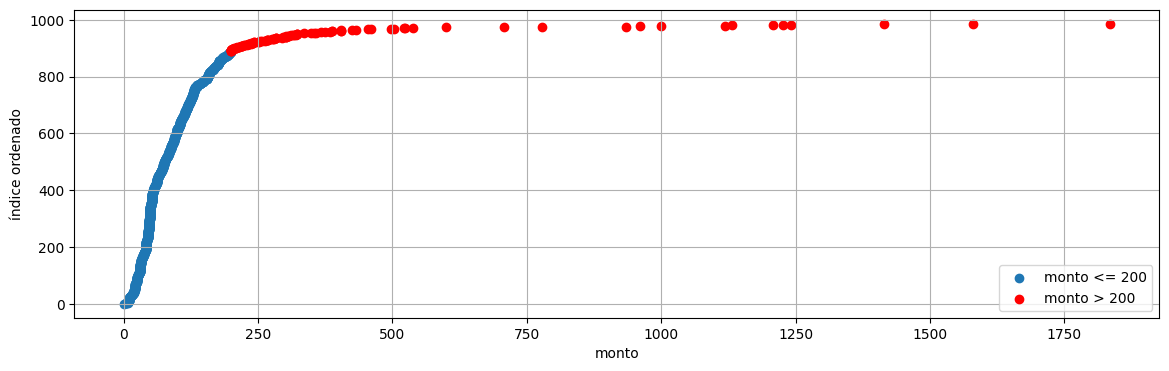

In [45]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_monto_scatter(ax)

In [46]:
monto_desc = describe_monto()

def _render_monto_count_rate(tipo, tipo_monto):
    (count, rate) = monto_desc.loc[(tipo, tipo_monto), ["count", "rate"]]
    return f"{count:.0f} ({100 * rate:.2f}%)"

for tipo in TIPOS_ALL:
    print(f"\ntipo={tipo}")
    print(f"monto bajo-medio: {_render_monto_count_rate(tipo, 'bajo-medio')}")
    print(f"monto alto: {_render_monto_count_rate(tipo, 'alto')}")


tipo=regular
monto bajo-medio: 824 (89.96%)
monto alto: 92 (10.04%)

tipo=rotativo
monto bajo-medio: 65 (91.55%)
monto alto: 6 (8.45%)

tipo=regular + rotativo
monto bajo-medio: 889 (90.07%)
monto alto: 98 (9.93%)


In [47]:
monto_desc

count      rate        mean         std  \
tipo               tipo_monto                                            
regular            alto         92.0  0.100437  397.151556  306.093143   
                   bajo-medio  824.0  0.899563   81.476116   48.060655   
regular + rotativo alto         98.0  0.099291  412.883849  327.089728   
                   bajo-medio  889.0  0.900709   79.067121   48.154960   
rotativo           alto          6.0  0.084507  654.112352  544.026514   
                   bajo-medio   65.0  0.915493   48.528473   38.077755   

                                     min         25%         50%         75%  \
tipo               tipo_monto                                                  
regular            alto        200.00000  231.643758  289.954235  391.260100   
                   bajo-medio    5.07485   45.412738   68.832070  115.586815   
regular + rotativo alto        200.00000  232.442990  295.596980  404.040400   
                   bajo-medio    0.39800   42.886610   63.836630  113.300000   
rotativo           alto        200.00000  260.786583  447.556970  899.577345   
                   bajo-medio    0.39800   24.903260   39.319600   50.000000   

                                      max  
tipo               tipo_monto              
regular            alto        1834.80000  
                   bajo-medio   199.92100  
regular + rotativo alto        1834.80000  
                   bajo-medio   199.92100  
rotativo           alto        1580.77958  
                   bajo-medio   196.83432

In [48]:
quantile_monto(quantiles=np.linspace(0.87, 1.0, num=14))

,regular + rotativo,regular,rotativo
0.87,180.149701,181.864652,103.362787
0.88,184.841571,188.672704,131.494572
0.89,195.101875,195.256315,152.487912
0.90,199.410340,199.960500,158.293040
0.91,202.542200,204.857350,185.271936
0.92,219.688502,219.706250,198.100592
0.93,237.692611,237.656102,204.934413
0.94,266.264941,266.801492,239.475304
0.95,291.728293,286.891343,272.229035
0.96,316.263330,315.879756,356.091152


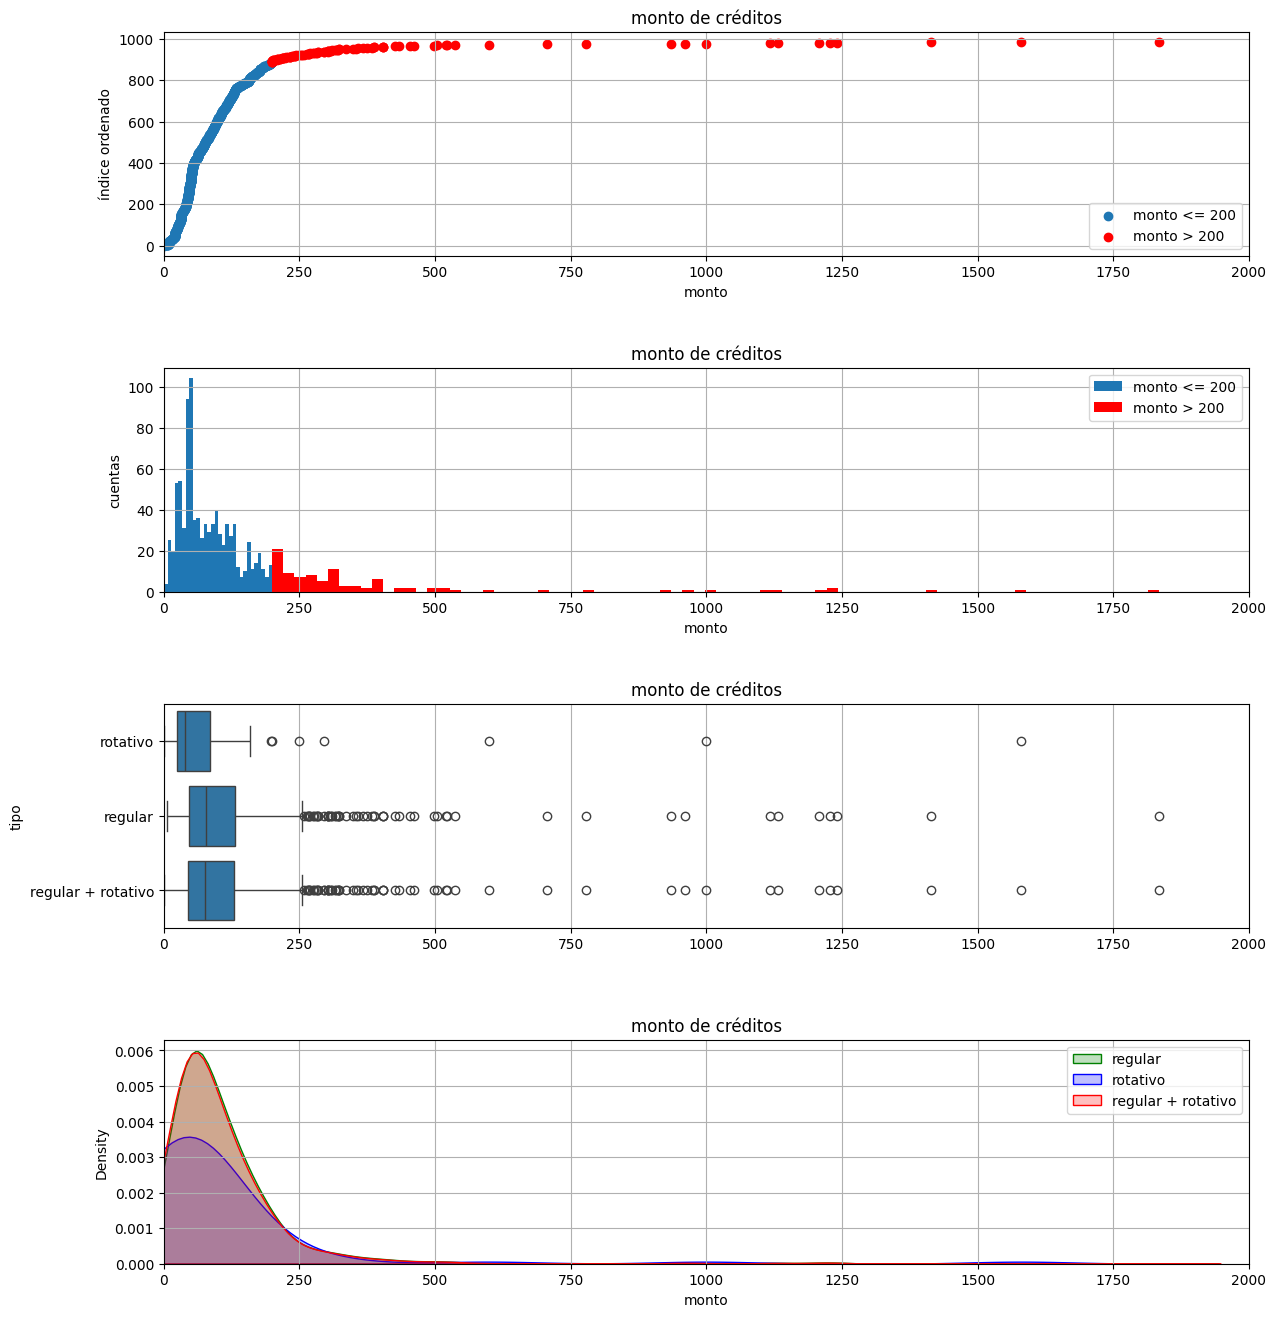

In [49]:
plot_monto(title="monto de créditos", xlim_max=2000)

Filtré entonces el conjunto de datos para descartar los créditos de montos altos y trabajar únicamente con créditos de monto bajo-medio:

In [50]:
df = df.query(f"monto <= {lim_low_mid}")

Una vez filtrados los datos de monto bajo-medio se aprecia mejor que el efecto de los créditos rotativos en la distribución de la variable "monto" es baja, tal como se esperaría por su menor número de observaciones. Igualmente se observa que la distribución de monto de créditos de monto bajo-medio es menor que la correspondiente a créditos de monto alto.

In [51]:
describe_monto()

,count,mean,std,min,25%,50%,75%,max
regular + rotativo,889.0,79.067121,48.154960,0.39800,42.886610,63.83663,113.300000,199.92100
regular,824.0,81.476116,48.060655,5.07485,45.412738,68.83207,115.586815,199.92100
rotativo,65.0,48.528473,38.077755,0.39800,24.903260,39.31960,50.000000,196.83432


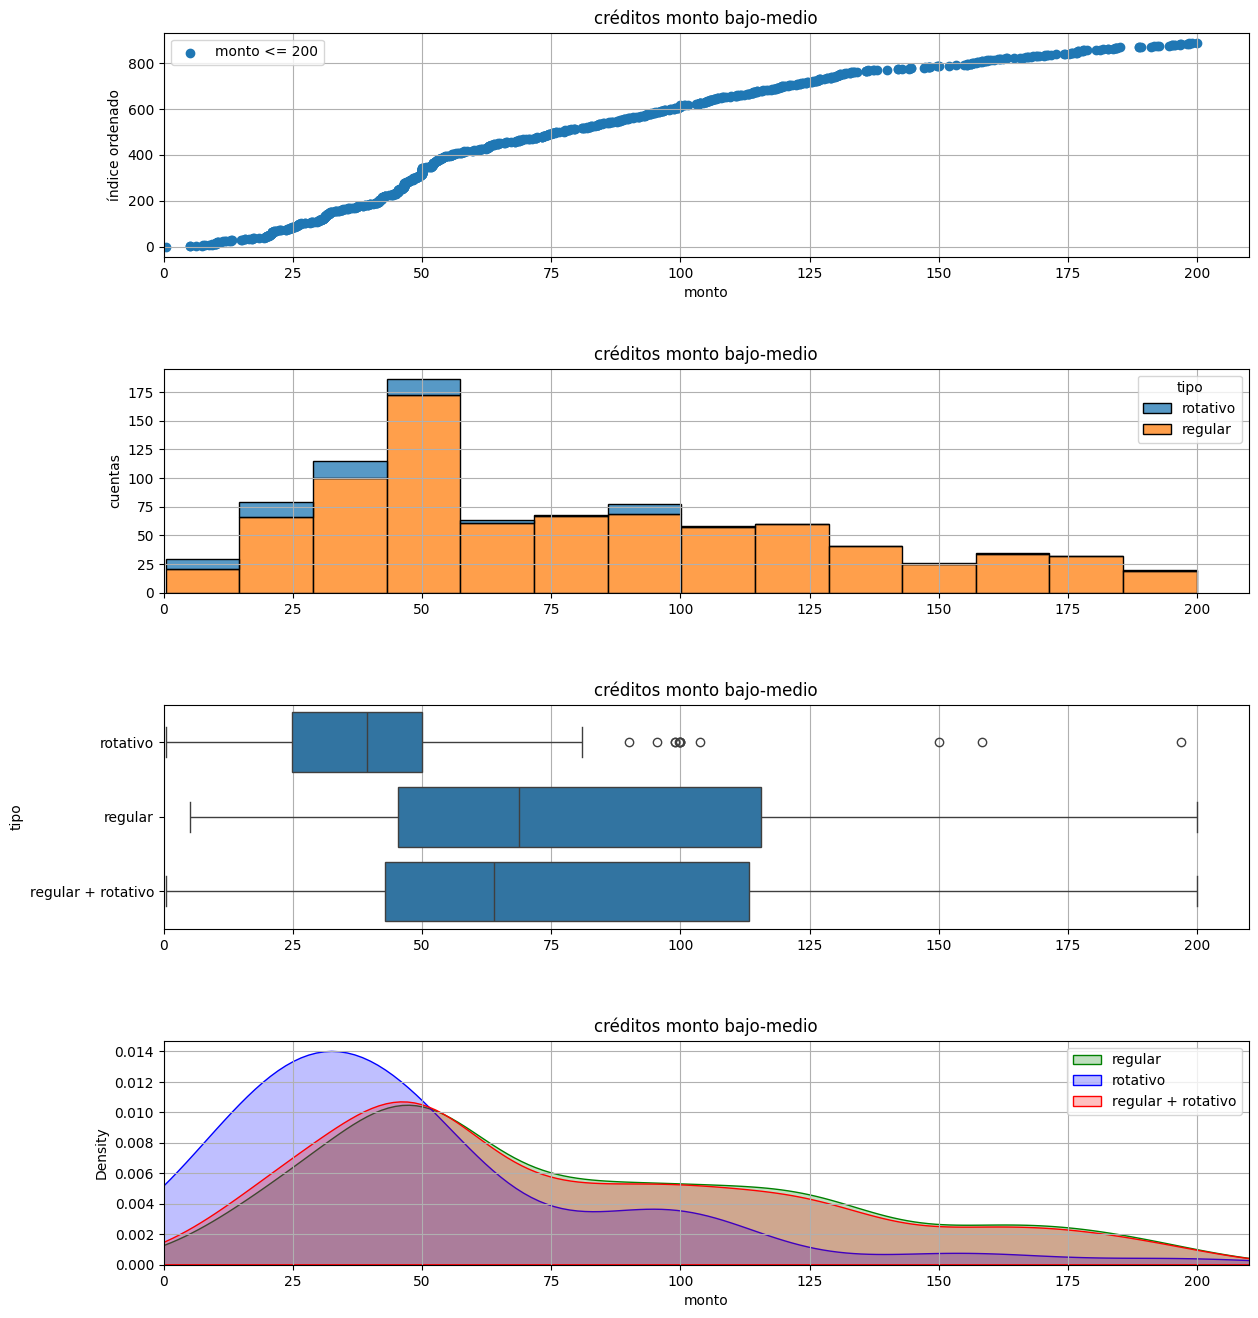

In [52]:
plot_monto(title="créditos monto bajo-medio", xlim_max=lim_low_mid + 10)

In [53]:
# emision, emision_semana

### Resumen de variables categóricas

En el resumen descriptivo de las variables categóricas se aprecia que no hay posibilidad de unificar los datos de créditos regulares y créditos rotativos, específicamente, las variables "destinacion_cod", "garantia_cod", y "pagaduria_cod" muestran que los créditos rotativos tienen características puntuales que no se comparten en los créditos regulares, más allá de las variables "categoria_cod" que clasifica la mora y "tipo_pago_cod" que describe dos posibles de métodos de pago.

In [54]:
sep = "----------------------"
categorical_not_tipo = [varname for varname in categorical if varname != "tipo"]
for category in categorical_not_tipo:
    print(f"\n\nvariable: {category}")
    print(sep)

    uvalues = sorted(df[category].unique())
    print(f"nunique: {len(uvalues)}")
    print(f"uvalues: {uvalues}")
    print(sep)

    desc = describe_categorical_var(category)
    print(total_categorical_desc(desc))
    print(sep)



variable: categoria_cod
----------------------
nunique: 5
uvalues: ['C1', 'C2', 'C3', 'C4', 'C5']
----------------------
tipo  regular           rotativo           regular + rotativo          
       counts     rates   counts     rates             counts     rates
C1      360.0  0.436893     13.0  0.200000              373.0  0.419573
C2       18.0  0.021845      2.0  0.030769               20.0  0.022497
C3      217.0  0.263350     39.0  0.600000              256.0  0.287964
C4      198.0  0.240291      7.0  0.107692              205.0  0.230596
C5       31.0  0.037621      4.0  0.061538               35.0  0.039370
TOTAL   824.0  1.000000     65.0  1.000000              889.0  1.000000
----------------------


variable: destinacion_cod
----------------------
nunique: 11
uvalues: ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C08', 'C09', 'C10', 'C18', 'C26']
----------------------
tipo  regular           rotativo       regular + rotativo          
       counts     rates   counts rate

In [55]:
sep = "----------------------"
for category in categorical_regular:
    print(f"\n\nvariable: {category}")
    print(sep)

    uvalues = sorted(df[category].dropna().unique())
    print(f"nunique: {len(uvalues)}")
    print(f"uvalues: {uvalues}")
    print(sep)

    desc = describe_categorical_var(category, tipos=["regular"])
    print(total_categorical_desc(desc))
    print(sep)



variable: estado_cliente_cod
----------------------
nunique: 2
uvalues: ['C1', 'C3']
----------------------
tipo  regular          
       counts     rates
C1      727.0  0.882282
C3       97.0  0.117718
TOTAL   824.0  1.000000
----------------------


variable: estado_laboral_cod
----------------------
nunique: 6
uvalues: ['C1', 'C2', 'C4', 'C5', 'C6', 'C7']
----------------------
tipo  regular          
       counts     rates
C1       30.0  0.036408
C2        1.0  0.001214
C4      443.0  0.537621
C5      128.0  0.155340
C6      143.0  0.173544
C7       79.0  0.095874
TOTAL   824.0  1.000000
----------------------


variable: oficina_cod
----------------------
nunique: 8
uvalues: ['C1', 'C2', 'C3', 'C4', 'C6', 'C7', 'C8', 'C9']
----------------------
tipo  regular          
       counts     rates
C1       11.0  0.013350
C2      148.0  0.179612
C3      133.0  0.161408
C4      113.0  0.137136
C6      273.0  0.331311
C7      122.0  0.148058
C8        2.0  0.002427
C9       22.0  0.02

### Resumen de variables numéricas

En el resumen descriptivo de las variables numéricas reafirma lo mencionado en cuanto a la poca

se aprecia que no hay posibilidad de unificar los datos de créditos regulares y créditos rotativos, específicamente, las variables "destinacion_cod", "garantia_cod", y "pagaduria_cod" muestran que los créditos rotativos tienen características puntuales que no se comparten en los créditos regulares, más allá de las variables "categoria_cod" que clasifica la mora y "tipo_pago_cod" que describe dos posibles de métodos de pago.


In [56]:
desc = pd.concat([df, df.assign(tipo=TIPO_JOINED)]).groupby("tipo")[numerical].describe()
desc = desc.loc[TIPOS_ALL]
desc.T

tipo              regular    rotativo  regular + rotativo
cuota   count  824.000000   65.000000          889.000000
        mean     2.900382    2.466223            2.868638
        std      1.358235    5.409841            1.957510
        min      0.190750    0.003660            0.003660
        25%      1.984935    0.265000            1.809300
        50%      2.711360    0.444980            2.668060
        75%      3.575330    1.418080            3.534510
        max     11.703020   25.297260           25.297260
monto   count  824.000000   65.000000          889.000000
        mean    81.476116   48.528473           79.067121
        std     48.060655   38.077755           48.154960
        min      5.074850    0.398000            0.398000
        25%     45.412738   24.903260           42.886610
        50%     68.832070   39.319600           63.836630
        75%    115.586815   50.000000          113.300000
        max    199.921000  196.834320          199.921000
ncuotas count  824.000000   65.000000          889.000000
        mean    47.201456   36.000000           46.382452
        std     25.922554    0.000000           25.125764
        min      1.000000   36.000000            1.000000
        25%     24.000000   36.000000           24.000000
        50%     45.000000   36.000000           36.000000
        75%     60.000000   36.000000           60.000000
        max    120.000000   36.000000          120.000000
tasa    count  824.000000   65.000000          889.000000
        mean     1.965773    1.966402            1.965819
        std      0.402639    0.266346            0.394163
        min      0.743804    1.723011            0.743804
        25%      1.766131    1.770364            1.770364
        50%      1.910510    1.875944            1.910296
        75%      2.100000    2.100000            2.100000
        max      2.809559    2.682829            2.809559

### Variable: categoria_cod

La distribución de la variable "categoria_cod" refleja una diferencia importante en el comportamiento de pago de créditos regulares versus créditos rotativos, por lo que en un modelamiento predictivo se debería considerar evaluar de manera independiente los créditos regulares y los créditos rotativos.

*Nota: las siguientes descripciones parten de la codificación aleatoria previa de las cinco categorías de mora definitas por Superfinanciera, el propósito es mostrar la distribución y el balance de las categorías para efectos de modelamiento*

In [57]:
varname = "categoria_cod"

desc = describe_categorical_var(varname)
total_categorical_desc(desc)

tipo  regular           rotativo           regular + rotativo          
       counts     rates   counts     rates             counts     rates
C1      360.0  0.436893     13.0  0.200000              373.0  0.419573
C2       18.0  0.021845      2.0  0.030769               20.0  0.022497
C3      217.0  0.263350     39.0  0.600000              256.0  0.287964
C4      198.0  0.240291      7.0  0.107692              205.0  0.230596
C5       31.0  0.037621      4.0  0.061538               35.0  0.039370
TOTAL   824.0  1.000000     65.0  1.000000              889.0  1.000000

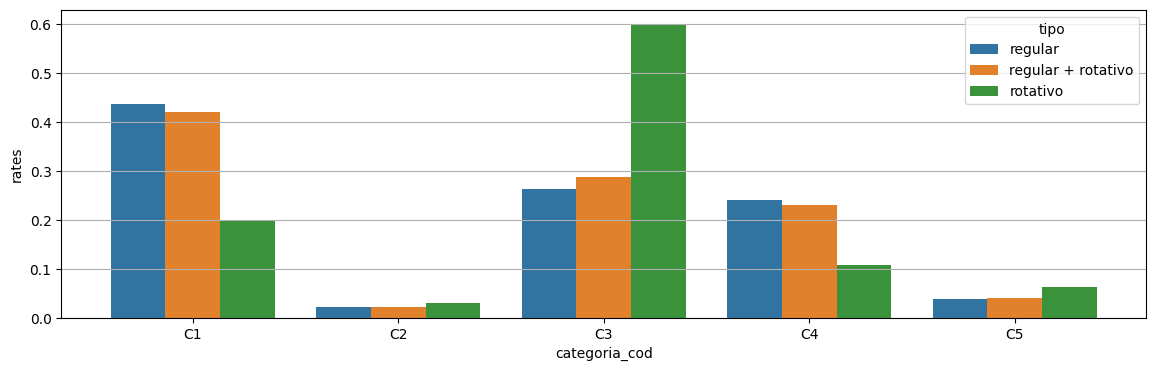

In [58]:
plot_categorical_desc_rates(desc, varname)

### Variable: cuota

In [59]:
df.groupby("tipo")["cuota"].describe()

,count,mean,std,min,25%,50%,75%,max
tipo,,,,,,,,
regular,824.0,2.900382,1.358235,0.19075,1.984935,2.71136,3.57533,11.70302
rotativo,65.0,2.466223,5.409841,0.00366,0.265000,0.44498,1.41808,25.29726


In [60]:
(df.groupby("tipo")["cuota"]).describe()

,count,mean,std,min,25%,50%,75%,max
tipo,,,,,,,,
regular,824.0,2.900382,1.358235,0.19075,1.984935,2.71136,3.57533,11.70302
rotativo,65.0,2.466223,5.409841,0.00366,0.265000,0.44498,1.41808,25.29726


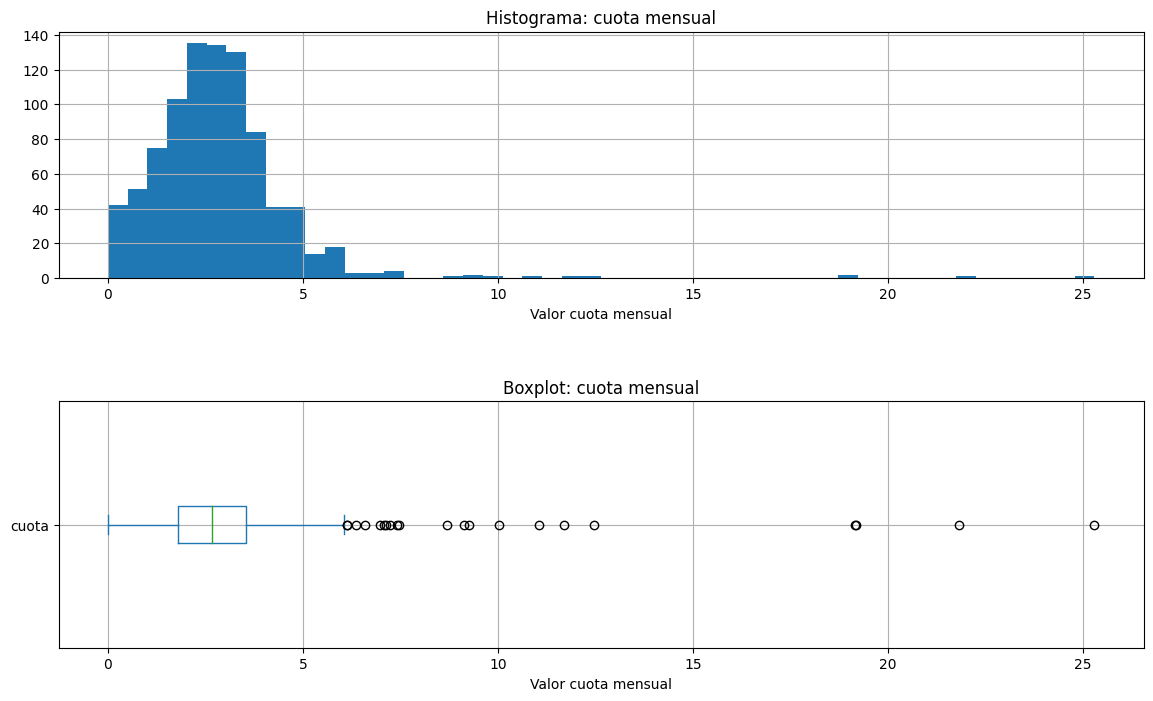

In [61]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

ax = axs[0]
df["cuota"].hist(ax=ax, bins=50, grid=True)
ax.set_title("Histograma: cuota mensual")
ax.set_xlabel("Valor cuota mensual")

ax = axs[1]
df["cuota"].plot.box(vert=False, ax=ax, grid=True)
ax.set_title("Boxplot: cuota mensual")
ax.set_xlabel("Valor cuota mensual")

axs[0].tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.5)
plt.plot();

### Variable: emision

La visualización de la distribución de la variable de fecha "emision" no muestra algún comportamiento particular a nivel univariado, sin embargo, se define la variable "emision_semana" como alternativa para evaluar posibles correlaciones de tiempo:

In [62]:
varname = "emision"
df[varname] = pd.to_datetime(df[varname], format="%d/%m/%Y")
df[varname]

0     2024-02-05
1     2022-12-16
2     2022-12-16
3     2024-03-22
4     2022-12-16
         ...    
884   2023-03-28
885   2023-02-28
886   2022-07-26
887   2024-06-19
888   2022-03-02
Name: emision, Length: 889, dtype: datetime64[ns]

In [63]:
df.groupby(df[varname].dt.year).size()

emision
2017      1
2018      9
2019     18
2020     63
2021    192
2022    305
2023    223
2024     78
dtype: int64

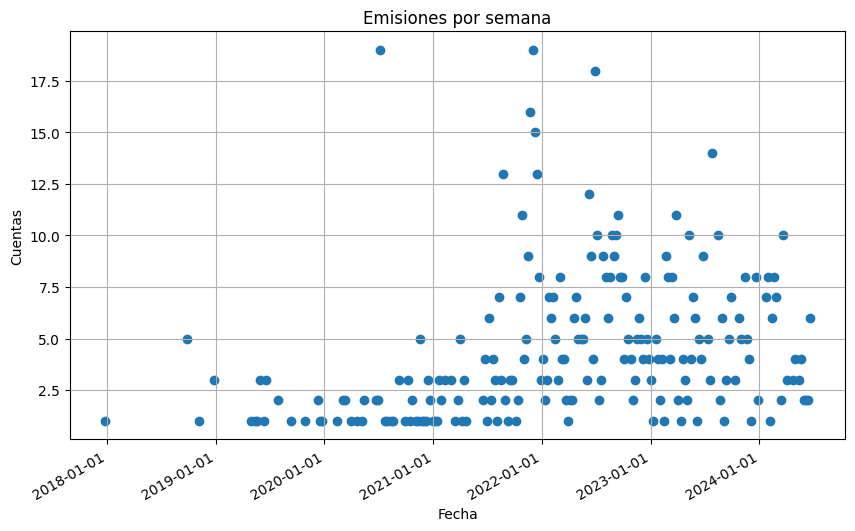

In [64]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# day_counts = df[varname].value_counts().sort_index()
# plt.scatter(day_counts.index, day_counts.values)
# plt.title('Emisiones por día')

df["emision_semana"] = df[varname].dt.to_period("W-MON").dt.start_time
week_counts = df.groupby("emision_semana").size()
plt.scatter(week_counts.index, week_counts.values)
plt.title('Emisiones por semana')

plt.xlabel('Fecha')
plt.ylabel('Cuentas')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.grid(True)
plt.show()

### Variable: ncuotas (número de cuotas)

La totalidad de los créditos rotativos tienen periodo de 36 meses (tres años):

In [65]:
counts_ncuotas = df.groupby("tipo")["ncuotas"].value_counts()
counts_ncuotas

tipo      ncuotas
regular   60         124
          36         119
          24         117
          48          98
          96          63
                    ... 
          93           1
          97           1
          99           1
          115          1
rotativo  36          65
Name: ncuotas, Length: 86, dtype: int64

Respecto a créditos regulares:

In [66]:
idx = pd.IndexSlice["regular", [24, 36, 48, 60, 96]]
rate = counts_ncuotas.loc[idx].sum() / counts_ncuotas["regular"].sum()

f"Cerca del {rate * 100:.2f}% de los créditos regulares tienen a periodos fijos de 24, 36, 48, 60, y 96 meses (2, 3, 4, 5, y 8 años)"

'Cerca del 63.23% de los créditos regulares tienen a periodos fijos de 24, 36, 48, 60, y 96 meses (2, 3, 4, 5, y 8 años)'

In [67]:
counts_ncuotas["regular"].head(10)

ncuotas
60     124
36     119
24     117
48      98
96      63
12      39
72      30
18      24
120     17
50      12
Name: ncuotas, dtype: int64

Dadas estas consideraciones, una opción a evaluar en una etapa de modelamiento predictivo es considerar el número de cuotas como una variable categórica, segmentando por rangos los valores distintos a 24, 36, 48, 60, y 96 meses, considerando que no hay un comporamiento continuo, es decir, la función de densidad dista de las distribución real de la variable.

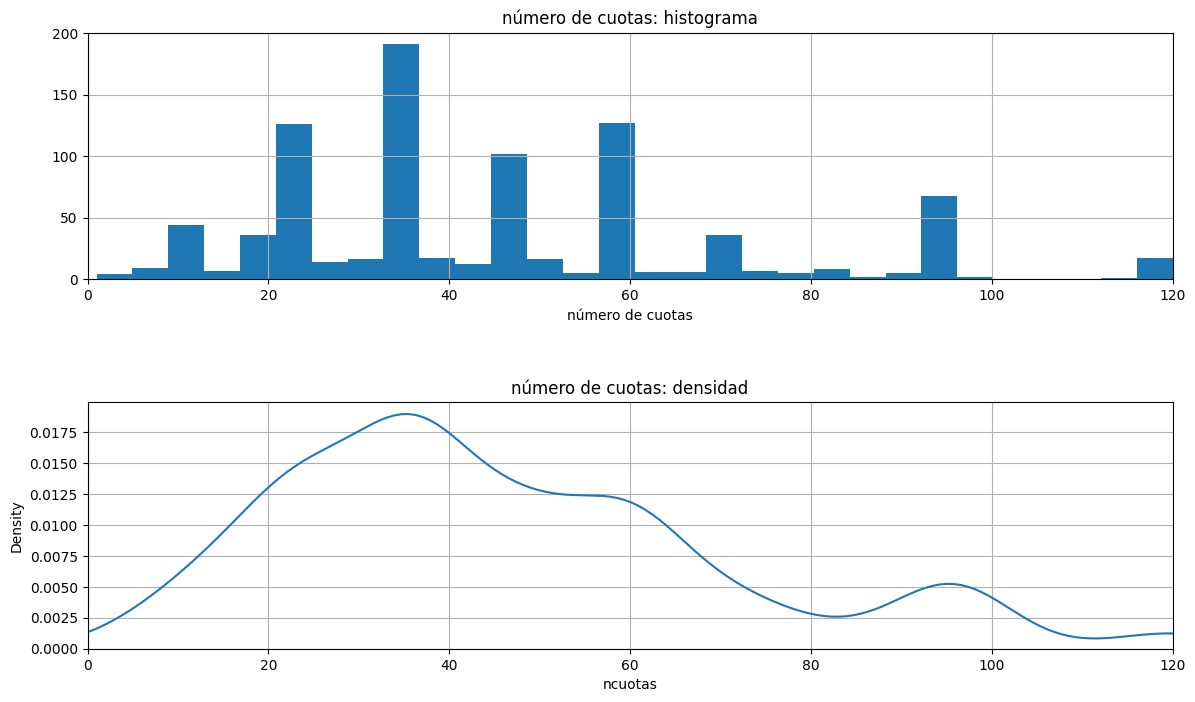

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax = axs[0]
df["ncuotas"].hist(ax=ax, bins=30)
ax.set_title("número de cuotas: histograma")
ax.set_xlabel("número de cuotas")

ax = axs[1]
sns.kdeplot(df["ncuotas"], label="regular", ax=ax)
ax.set_title("número de cuotas: densidad")

xlim_max = df["ncuotas"].max()
for ax in axs:
    ax.set_xlim(0, xlim_max)
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(hspace=0.5)
plt.show()

### Variable: tasa

Los valores de tasa se encuentran en los rangos esperados para el servicio de crédito:

In [69]:
df = sort_by("tasa")

df.groupby("tipo")["tasa"].describe()

,count,mean,std,min,25%,50%,75%,max
tipo,,,,,,,,
regular,824.0,1.965773,0.402639,0.743804,1.766131,1.910510,2.1,2.809559
rotativo,65.0,1.966402,0.266346,1.723011,1.770364,1.875944,2.1,2.682829


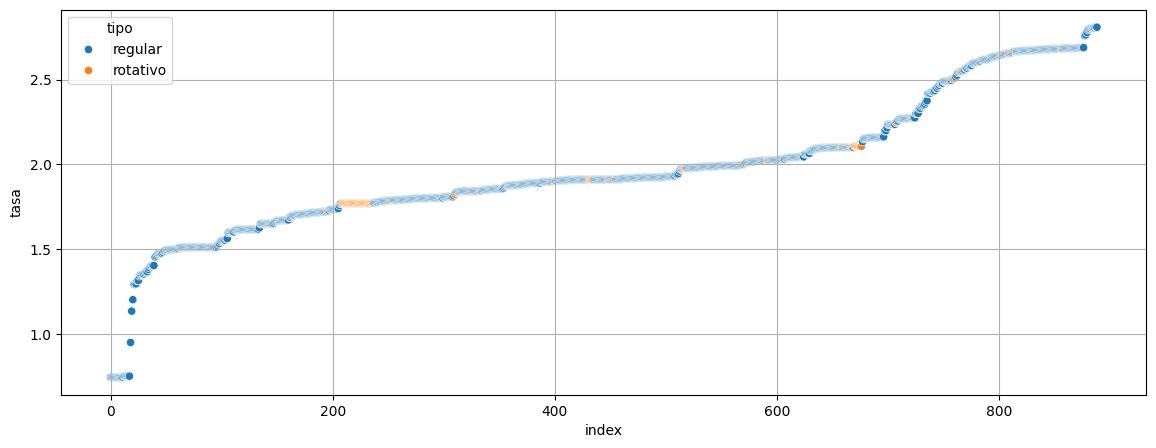

In [70]:
plt.figure(figsize=(14, 5))
sns.scatterplot(df.reset_index(), x="index", y="tasa", hue="tipo");

### Distribuciones bivariadas y correlaciones

Las distribuciones bivariadas y las correlaciones muestran un grado de correlación entre las variables "monto" (monto de crédito), "ncuotas" (número de cuotas), y "cuota" (valor de cuota mensual), siendo esto esperado dado que describen en general la tamaño de un crédito.

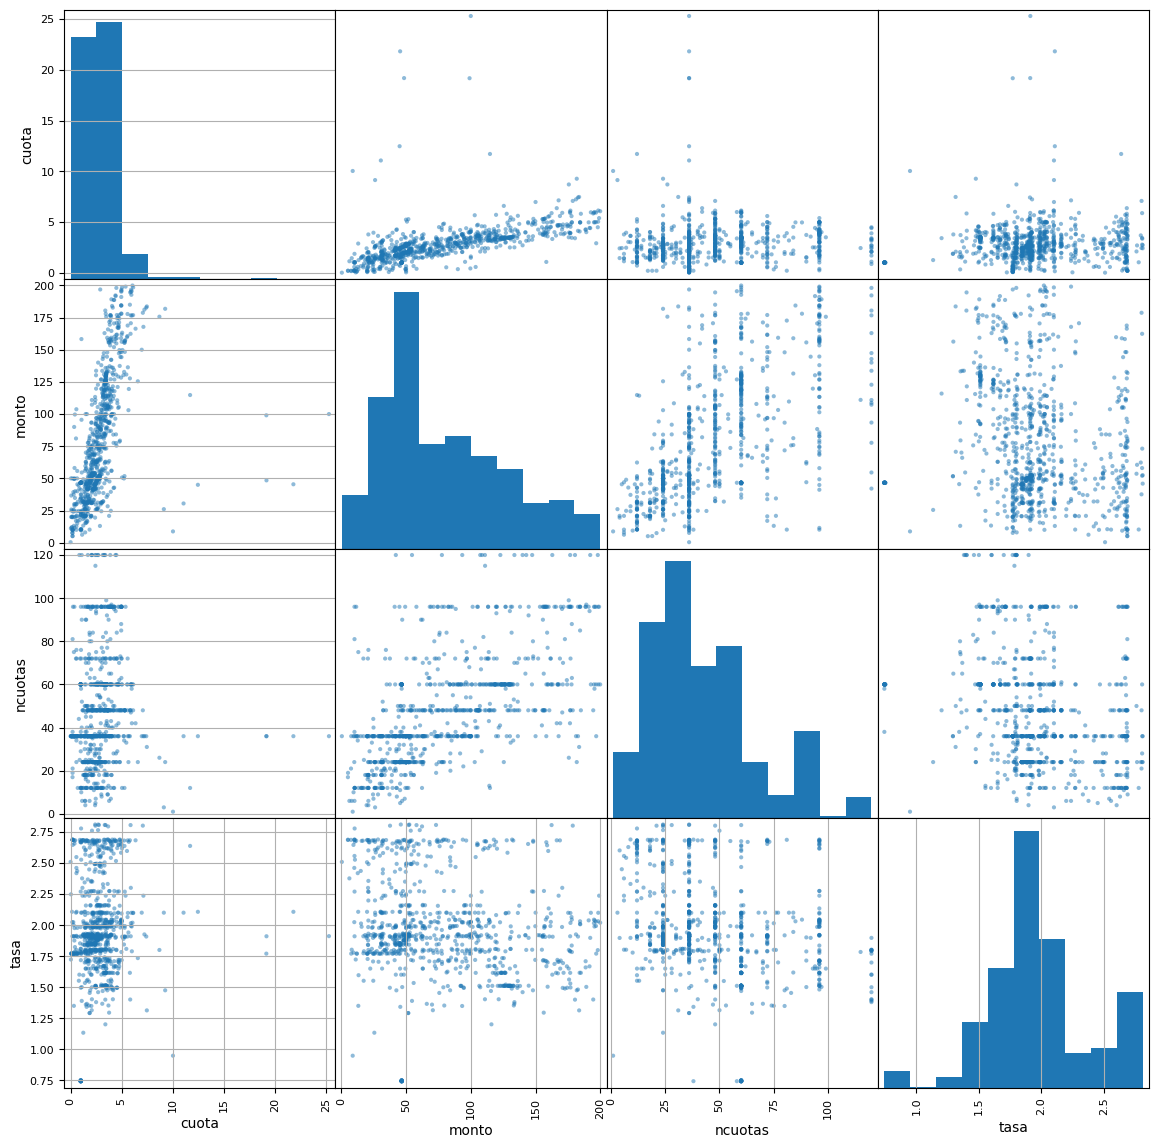

In [71]:
pd.plotting.scatter_matrix(df, figsize=(14, 14));
plt.plot();

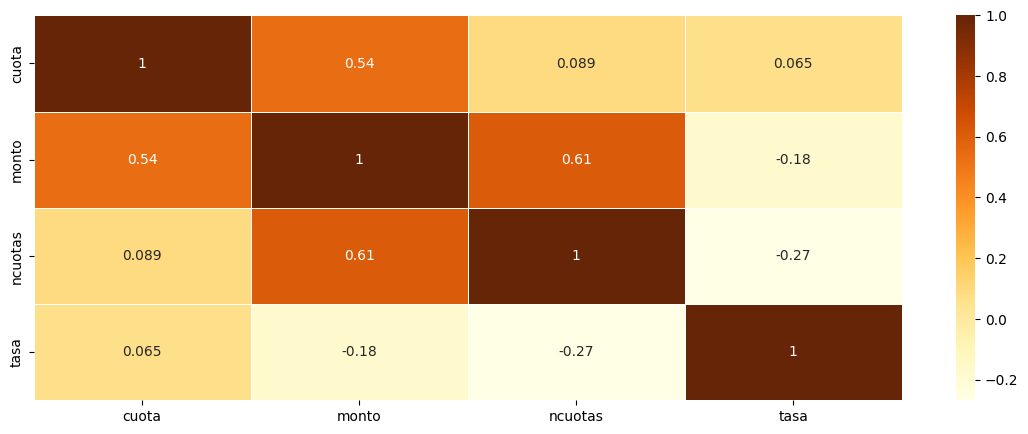

In [72]:
corr = df.corr()

plt.figure(figsize=(14, 5))
cmap =sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, linewidths=0.5)
plt.show()

In [73]:
df.to_parquet(DATA_PROCESSED_FILE)